In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [33]:
import torchvision.transforms as transforms

In [6]:
!pip install wandb
!wandb login c65fef72e0240cc4cc1477580c8142ecbef16bca
import wandb
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="Nepali handwritten",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 5e-7,
    "architecture": "TrOCR",
    "dataset": "custom",
    "epochs": 5,
    }
)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ankitshrestha (ankitshrestha-kathmandu-engineering-college). Use `wandb login --relogin` to force relogin


In [7]:
from huggingface_hub import notebook_login

notebook_login()

In [13]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image

# Load the fine-tuned model and processor
model = VisionEncoderDecoderModel.from_pretrained("rockerritesh/trOCR_ne")
processor = TrOCRProcessor.from_pretrained("rockerritesh/trOCR_ne")

config.json:   0%|          | 0.00/4.74k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/178M [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.deit.modeling_deit.DeiTModel'> is overwritten by shared encoder config: DeiTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 384,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "model_type": "deit",
  "num_attention_heads": 6,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.47.0"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 384,
  "d_model": 256,
  "decoder_attention_heads": 8,
  "decoder_ffn_dim": 1024,
  "decode

generation_config.json:   0%|          | 0.00/303 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/529k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.01M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [14]:
import chardet
with open("/kaggle/input/ocr-labels/labels.csv", "rb") as file:
    raw_data = file.read()
    result = chardet.detect(raw_data)
    encoding = result['encoding']    

In [15]:
df = pd.read_csv('/kaggle/input/ocr-labels/labels.csv',encoding = encoding,header=None,names=['combined'])

In [16]:
df['image_path'] = df['combined'].str.split(' ').str[0]
df['label'] = df['combined'].str.split(' ').str[1]
df.drop(columns=['combined'])
df["image_path"] = df["image_path"].apply(lambda x: f"/kaggle/input/ocr-labels/crops/{x}")

In [17]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.1)
# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [18]:
def preprocess(row):
    try:
        # Load and process image
        image = Image.open(row['image_path']).convert("RGB")
        pixel_values = processor(images=image, return_tensors="pt")["pixel_values"].squeeze(0)

        # Tokenize label
        label_ids = processor.tokenizer(row["label"], padding="max_length", truncation=True, return_tensors="pt")["input_ids"].squeeze(0)

        return {"pixel_values": pixel_values, "input_ids": label_ids}
    except Exception as e:
        print(f"Error processing {row['image_name']}: {e}")
        return None

In [19]:
df["processed"] = df.apply(preprocess, axis=1)
df = df.dropna() 

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [20]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class Dataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=47):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length
    def __getitem__(self, idx):
        # get file name + text 
        file_name = self.df['image_path'][idx]
        text = self.df['label'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(
            text, 
            padding="max_length", 
            max_length=self.max_target_length, 
            truncation=True  # Add this line
        ).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]
    
        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding


    def __len__(self):
        return len(self.df)

In [21]:
train_dataset = Dataset(root_dir='',
                           df=train_df,
                           processor=processor)
eval_dataset = Dataset(root_dir='',
                           df=test_df,
                           processor=processor)

In [22]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 3922
Number of validation examples: 436


In [23]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=32)

In [24]:
! pip install evaluate -q
! pip install jiwer -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 43.0 MB/s eta 0:00:0000:0100:01


In [25]:
import evaluate

# Load CER and WER metrics
cer_metric = evaluate.load("cer")
wer_metric = evaluate.load("wer")

In [26]:
def compute_cer(pred_ids, label_ids):
    pred_str = processor.tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return cer

def compute_wer(pred_ids, label_ids):
    pred_str = processor.tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return wer

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTSdpaAttention(
            (attention): DeiTSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense):

In [37]:
from transformers import AdamW
from tqdm.notebook import tqdm
from torch.optim.lr_scheduler import LambdaLR

train_loss_list = []
CER_list = []
WER_list = []
optimizer = AdamW(model.parameters(), lr=5e-7,no_deprecation_warning=True)
print("Learning rate =", optimizer.param_groups[0]['lr'])


for epoch in range(5):  # loop over the dataset multiple times
    # train
    model.train()
    train_loss = 0.0
    for batch in tqdm(train_dataloader):
        # get the inputs
        for k,v in batch.items():
            batch[k] = v.to(device)

        # forward + backward + optimize
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()
        # log metrics to wandb
        wandb.log({"train_loss": train_loss, "lr": optimizer.param_groups[0]['lr']})
        
    train_loss_list.append(train_loss/len(train_dataloader))
    print(f"Loss after epoch {epoch}:", train_loss/len(train_dataloader))
    print("Learning rate =", optimizer.param_groups[0]['lr'])
    

    # evaluate
    model.eval()
    valid_cer = 0.0
    valid_wer = 0.0
    with torch.no_grad():
        for batch in tqdm(eval_dataloader):
            # run batch generation
            outputs = model.generate(batch["pixel_values"].to(device))
            # compute metrics
            cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
            wer = compute_wer(pred_ids=outputs, label_ids=batch["labels"])
            valid_cer += cer 
            valid_wer += wer

            # log metrics to wandb
            # wandb.log({"val_cer": valid_cer, "val_wer": valid_wer})
            
    CER_list.append(valid_cer / len(eval_dataloader))
    WER_list.append(valid_wer / len(eval_dataloader))
    print("Validation CER:", valid_cer / len(eval_dataloader))
    print("Validation WER:", valid_wer / len(eval_dataloader))

model.save_pretrained(".")

Learning rate = 5e-07


  0%|          | 0/123 [00:00<?, ?it/s]

Loss after epoch 0: 0.26051533779477687
Learning rate = 5e-07


  0%|          | 0/14 [00:00<?, ?it/s]

Validation CER: 0.21025881169525182
Validation WER: 0.44302823402088104


  0%|          | 0/123 [00:00<?, ?it/s]

Loss after epoch 1: 0.23800468390307775
Learning rate = 5e-07


  0%|          | 0/14 [00:00<?, ?it/s]

Validation CER: 0.20508247116240547
Validation WER: 0.4416252864782276


  0%|          | 0/123 [00:00<?, ?it/s]

Loss after epoch 2: 0.22741940205659322
Learning rate = 5e-07


  0%|          | 0/14 [00:00<?, ?it/s]

Validation CER: 0.2009263277275694
Validation WER: 0.4391981792717087


  0%|          | 0/123 [00:00<?, ?it/s]

Loss after epoch 3: 0.21872565795372173
Learning rate = 5e-07


  0%|          | 0/14 [00:00<?, ?it/s]

Validation CER: 0.19902802874093586
Validation WER: 0.4391981792717087


  0%|          | 0/123 [00:00<?, ?it/s]

Loss after epoch 4: 0.2127754197614949
Learning rate = 5e-07


  0%|          | 0/14 [00:00<?, ?it/s]

Validation CER: 0.19652113120663284
Validation WER: 0.4391981792717087


In [40]:
from transformers import AdamW
from tqdm.notebook import tqdm
from torch.optim.lr_scheduler import LambdaLR

train_loss_list = []
CER_list = []
WER_list = []
optimizer = AdamW(model.parameters(), lr=5e-7,no_deprecation_warning=True)
print("Learning rate =", optimizer.param_groups[0]['lr'])


for epoch in range(5):  # loop over the dataset multiple times
    # train
    model.train()
    train_loss = 0.0
    for batch in tqdm(train_dataloader):
        # get the inputs
        for k,v in batch.items():
            batch[k] = v.to(device)

        # forward + backward + optimize
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()
        # log metrics to wandb
        wandb.log({"train_loss": train_loss, "lr": optimizer.param_groups[0]['lr']})
        
    train_loss_list.append(train_loss/len(train_dataloader))
    print(f"Loss after epoch {epoch}:", train_loss/len(train_dataloader))
    print("Learning rate =", optimizer.param_groups[0]['lr'])
    

    # evaluate
    model.eval()
    valid_cer = 0.0
    valid_wer = 0.0
    with torch.no_grad():
        for batch in tqdm(eval_dataloader):
            # run batch generation
            outputs = model.generate(batch["pixel_values"].to(device))
            # compute metrics
            cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
            wer = compute_wer(pred_ids=outputs, label_ids=batch["labels"])
            valid_cer += cer 
            valid_wer += wer

            # log metrics to wandb
            # wandb.log({"val_cer": valid_cer, "val_wer": valid_wer})
            
    CER_list.append(valid_cer / len(eval_dataloader))
    WER_list.append(valid_wer / len(eval_dataloader))
    print("Validation CER:", valid_cer / len(eval_dataloader))
    print("Validation WER:", valid_wer / len(eval_dataloader))

model.save_pretrained(".")

Learning rate = 5e-07


  0%|          | 0/123 [00:00<?, ?it/s]

Loss after epoch 0: 0.20883354238741766
Learning rate = 5e-07


  0%|          | 0/14 [00:00<?, ?it/s]

Validation CER: 0.19696869599826541
Validation WER: 0.43696603641456583


  0%|          | 0/123 [00:00<?, ?it/s]

Loss after epoch 1: 0.20382238243047784
Learning rate = 5e-07


  0%|          | 0/14 [00:00<?, ?it/s]

Validation CER: 0.198347140742881
Validation WER: 0.4413626814362109


  0%|          | 0/123 [00:00<?, ?it/s]

Loss after epoch 2: 0.19945211024061452
Learning rate = 5e-07


  0%|          | 0/14 [00:00<?, ?it/s]

Validation CER: 0.19854451047339097
Validation WER: 0.43696603641456583


  0%|          | 0/123 [00:00<?, ?it/s]

Loss after epoch 3: 0.1965911745177052
Learning rate = 5e-07


  0%|          | 0/14 [00:00<?, ?it/s]

Validation CER: 0.20099409412020494
Validation WER: 0.44359482429335373


  0%|          | 0/123 [00:00<?, ?it/s]

Loss after epoch 4: 0.1950639452997262
Learning rate = 5e-07


  0%|          | 0/14 [00:00<?, ?it/s]

Validation CER: 0.20036051485118556
Validation WER: 0.4479238286223581


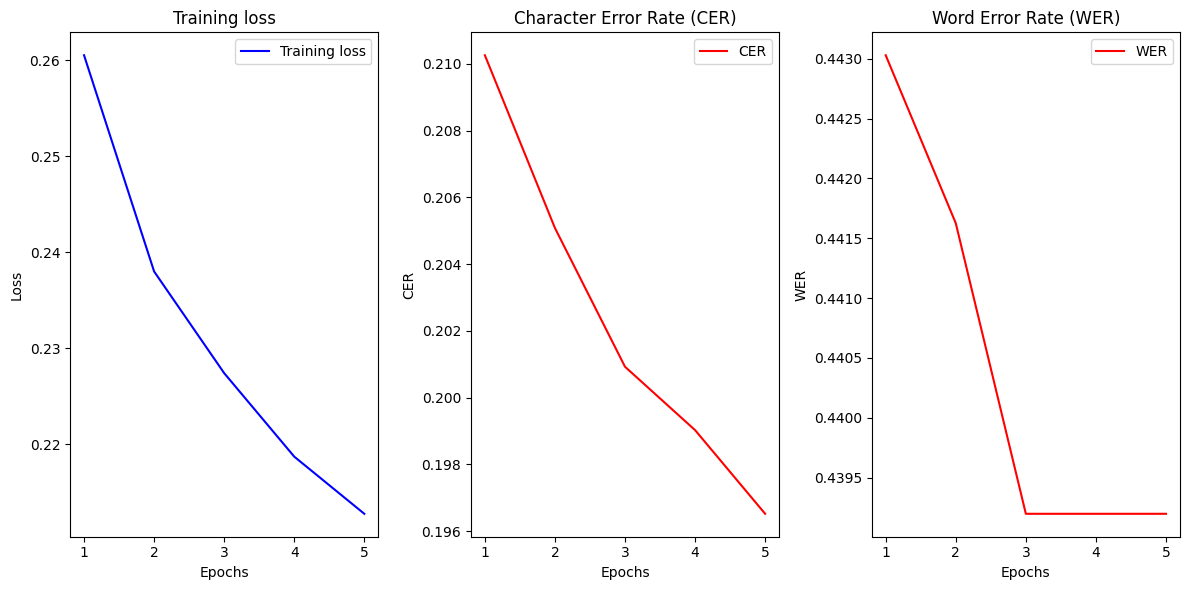

In [38]:
# Assuming loss and CER contain values for each epoch
epochs = range(1, len(train_loss_list) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.plot(epochs, train_loss_list, 'b', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, CER_list, 'r', label='CER')
plt.title('Character Error Rate (CER)')
plt.xlabel('Epochs')
plt.ylabel('CER')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, WER_list, 'r', label='WER')
plt.title('Word Error Rate (WER)')
plt.xlabel('Epochs')
plt.ylabel('WER')
plt.legend()

plt.tight_layout()
plt.show()

In [39]:
# Define the display function
def display_image_with_text(image_path, label, text, size=(300, 2000)):
    image = plt.imread(image_path)
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(size),
        transforms.ToTensor()
    ])
    image_tensor = transform(image)
    
    image_np = image_tensor.permute(1, 2, 0).cpu().numpy()
    plt.imshow(image_np)
    print("Label: "+label)
    print("Generated: "+text)
    plt.axis('off')
    plt.show()

Label: बाटोमा
Generated: बाटोमा


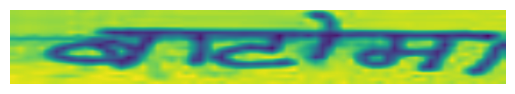

Label: भएको
Generated: भएको


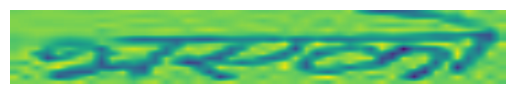

Label: हामी
Generated: हामी


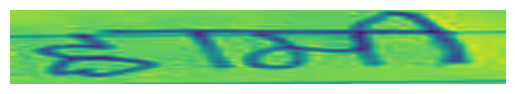

Label: प्रक्तिक
Generated: पराकताव


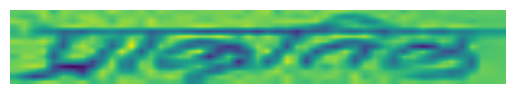

Label: गरेको
Generated: गरको


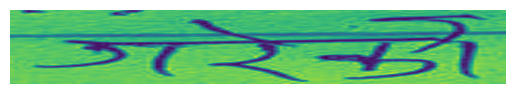

Label: विषयमा
Generated: विषयमा


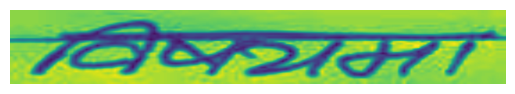

Label: सिकाउॅछ
Generated: सिकाउछ


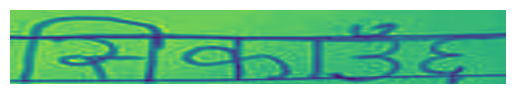

Label: आज
Generated: आज


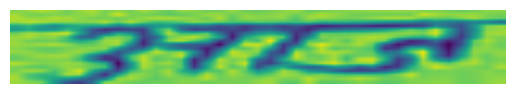

Label: विश्वमा
Generated: विशवमा


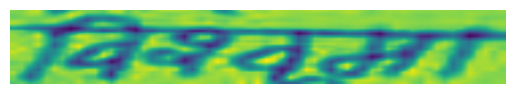

Label: नजान
Generated: नजान


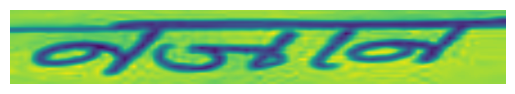

Label: भएको
Generated: भएको


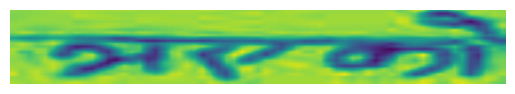

Label: यस्तो
Generated: यसतो


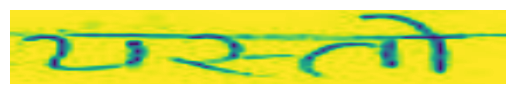

Label: अवस्या
Generated: अपकया


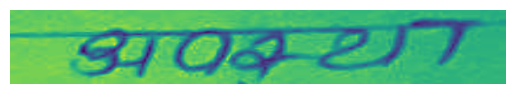

Label: चाॅहि
Generated: चाहि


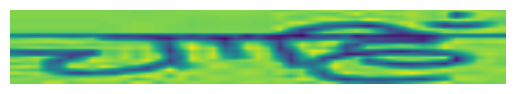

Label: कक्षा
Generated: ककषा


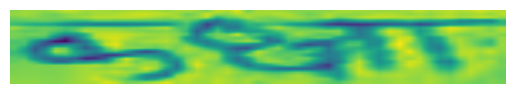

Label: stone
Generated: इनकाएर


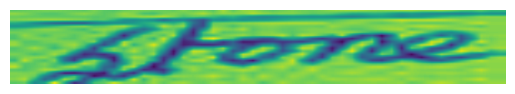

Label: वनस्पतिलाई
Generated: वनसयपतिलाई


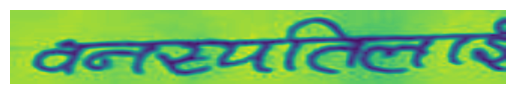

Label: उहाॅबाट
Generated: उहाबाट


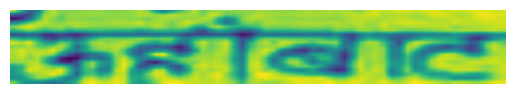

Label: अध्ययनले
Generated: अधययनल


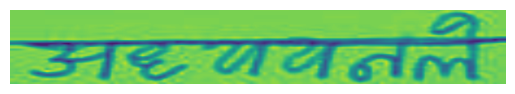

Label: परिपूर्ति
Generated: परिपरति


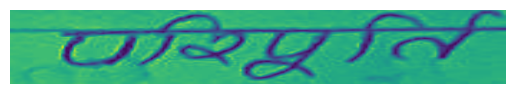

Label: हुँदै
Generated: हदद


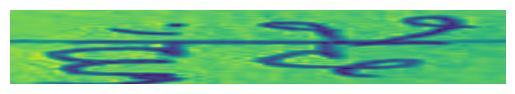

Label: लागि
Generated: लागि


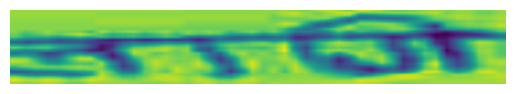

Label: मेरो
Generated: मरो


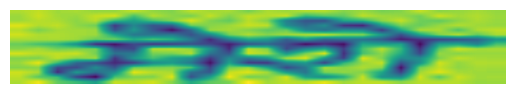

Label: मेरा
Generated: मरा


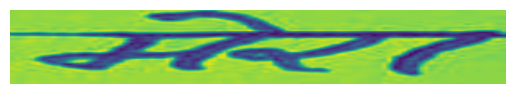

Label: बाटोमा
Generated: बाटोमा


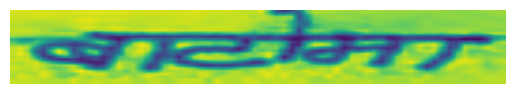

Label: हनाको
Generated: हवाको


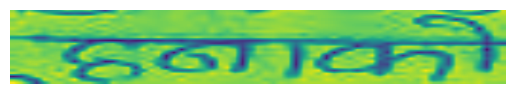

Label: लगाउॅछु
Generated: लगाउछ


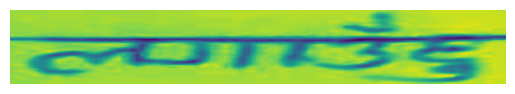

Label: खाइ
Generated: रहाइ


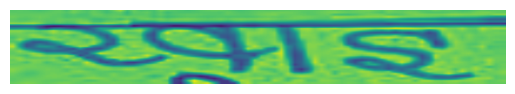

Label: २०७८/०७९
Generated: २०७katesss


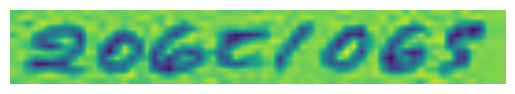

Label: आदर
Generated: आदर


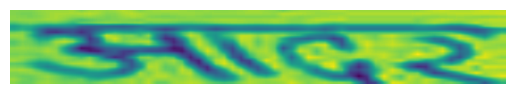

In [36]:
from PIL import Image

# Generate predictions for the test set
for index, row in test_df.head(30).iterrows():
    # Load the image
    image_path = row['image_path']
    original_label = row['label']
    
    # Load and process the image
    image = Image.open(image_path).convert("RGB")
    pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)

    # Generate prediction
    outputs = model.generate(pixel_values)
    predicted_text = processor.tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

    # Display the image with original and predicted text
    display_image_with_text(image_path, original_label, predicted_text)